In [1]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

2025-11-04 18:17:11.758708: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-04 18:17:12.357498: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
data_path = '../data/ISIC_2019_Training_Input'
csv_path = '../data/ISIC_2019_Training_GroundTruth.csv'

df = pd.read_csv(csv_path)

df['image_path'] = df['image'].apply(lambda x: os.path.join(data_path, x + '.jpg'))

class_columns = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK']
df['label'] = df[class_columns].idxmax(axis=1)

train_df, temp_df = train_test_split(df, test_size = 0.3, stratify = df['label'], random_state = 42)
val_df, test_df = train_test_split(temp_df, test_size = 0.5, stratify = temp_df['label'], random_state = 42)

target_size = (224, 224) 
batch_size = 16 

val_test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col = 'image_path',
    y_col = 'label',
    target_size = target_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False   
)

Found 3800 validated image filenames belonging to 8 classes.


In [3]:
def focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        pt = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        focal_weight = tf.pow(1 - pt, gamma)
        return -tf.reduce_mean(alpha * focal_weight * tf.math.log(pt))
    return loss

In [4]:
model = load_model('best_final_model.keras', compile = False)

2025-11-04 18:17:13.131822: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-11-04 18:17:13.159048: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-11-04 18:17:13.161904: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [5]:
model.compile(
    optimizer = Adam(5e-6),
    loss=focal_loss(gamma=2.0, alpha=0.25),
    metrics = ['Accuracy']
)

In [6]:
test_generator.reset()
y_pred = model.predict(test_generator, verbose = 1)
y_pred_classes = np.argmax(y_pred, axis = 1)
y_true = test_generator.classes

/home/elnaz/anaconda3/envs/tf-gpu/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1762267636.871512    6585 service.cc:145] XLA service 0x738c740023e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762267636.871533    6585 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-11-04 18:17:16.954265: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-04 18:17:17.337568: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8902
202

  2/238 ━━━━━━━━━━━━━━━━━━━━ 17s 74ms/step   

I0000 00:00:1762267652.508552    6585 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


237/238 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step 

2025-11-04 18:18:20.542022: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 0: 0.142456, expected -nan
2025-11-04 18:18:20.542067: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 1: 0.202148, expected 0
2025-11-04 18:18:20.542073: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 2: 0.123108, expected -nan
2025-11-04 18:18:20.542077: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 3: 0.14856, expected 0
2025-11-04 18:18:20.542080: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 4: 0.164917, expected -nan
2025-11-04 18:18:20.542083: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 5: 0.128174, expected 0
2025-11-04 18:18:20.542086: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 6: 0.130737, expected -nan
2025-11-04 18:18:20.542090: E external/local_xla/xla/service/gpu/buffer_comparator.cc:

238/238 ━━━━━━━━━━━━━━━━━━━━ 74s 239ms/step


In [10]:
class_names = list(test_generator.class_indices.keys())
print(classification_report(y_true, y_pred_classes, target_names = class_names))

              precision    recall  f1-score   support

          AK       0.46      0.58      0.52       130
         BCC       0.79      0.68      0.73       499
         BKL       0.60      0.52      0.56       393
          DF       0.60      0.67      0.63        36
         MEL       0.67      0.57      0.61       679
          NV       0.84      0.90      0.87      1931
         SCC       0.45      0.61      0.52        94
        VASC       0.83      0.79      0.81        38

    accuracy                           0.75      3800
   macro avg       0.65      0.67      0.66      3800
weighted avg       0.75      0.75      0.75      3800



In [11]:
cm = confusion_matrix(y_true, y_pred_classes)
cm

array([[  76,   17,   12,    0,    9,    5,   11,    0],
       [  41,  341,   21,    4,   27,   31,   30,    4],
       [  16,   17,  205,    2,   60,   74,   18,    1],
       [   1,    0,    0,   24,    1,    9,    1,    0],
       [  15,   24,   33,    2,  385,  216,    4,    0],
       [   8,   21,   66,    4,   85, 1741,    5,    1],
       [   7,   10,    6,    3,    7,    4,   57,    0],
       [   0,    2,    0,    1,    1,    3,    1,   30]])

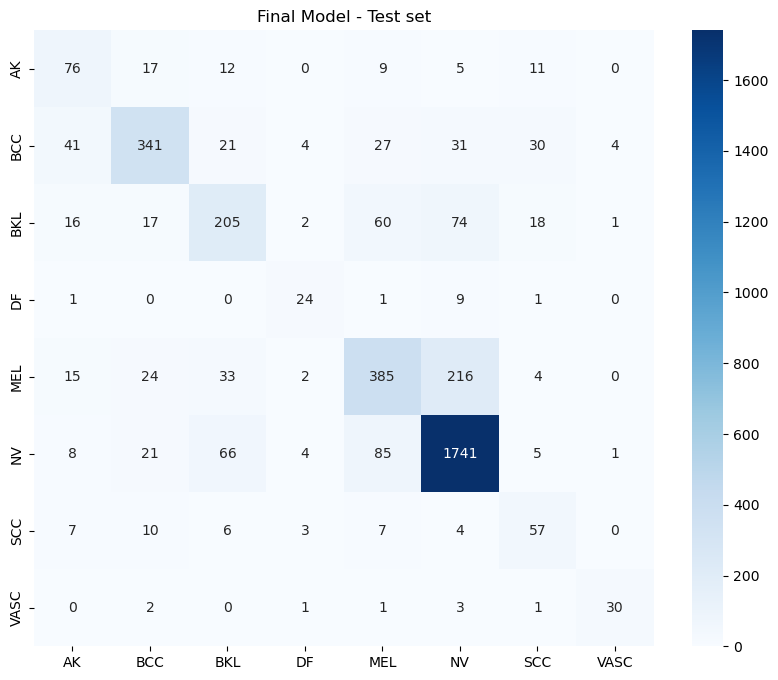

In [12]:
plt.figure(figsize = (10, 8))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = class_names, yticklabels = class_names)
plt.title('Final Model - Test set')
plt.savefig('final test')
plt.show()